<a href="https://colab.research.google.com/github/itsnotming/Project-1/blob/main/Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [21]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [27]:
import pandas as pd
from pathlib import Path
import re

IMG_DIR = Path("/content/gdrive/MyDrive/STATGR5243/downsampled_data")
METADATA_PATH = Path("/content/gdrive/MyDrive/STATGR5243/metadata_BR00116991.csv")

# Load metadata
df = pd.read_csv(METADATA_PATH)

# Pattern to extract rXXcXXfXX from metadata filenames
pattern = re.compile(r'^(r\d{2}c\d{2}f\d{2})')

valid_rows = []
for _, row in df.iterrows():
    orig_name = row["FileName_OrigRNA"]
    m = pattern.match(orig_name)
    if not m:
        continue

    prefix = m.group(1)  # e.g., r03c06f04
    matched_filename = f"{prefix}_median_aggregated.tiff"
    full_path = IMG_DIR / matched_filename

    if full_path.is_file():
        row["FileName_OrigRNA"] = matched_filename
        valid_rows.append(row)

filtered_df = pd.DataFrame(valid_rows)
print(f"Filtered down to {len(filtered_df)} valid images.")

Filtered down to 2867 valid images.


In [28]:
from sklearn.model_selection import train_test_split

# Set input features and labels
X = filtered_df["FileName_OrigRNA"]
y = filtered_df["Metadata_pert_iname"]  # compound names

# Train/test split
train_fnames, test_fnames, train_labels, test_labels = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Build and save the split DataFrames
train_df = pd.DataFrame({
    "FileName_OrigRNA": train_fnames,
    "Metadata_pert_iname": train_labels
})
test_df = pd.DataFrame({
    "FileName_OrigRNA": test_fnames,
    "Metadata_pert_iname": test_labels
})

train_csv_path = "/content/gdrive/MyDrive/STATGR5243/train_filtered.csv"
test_csv_path = "/content/gdrive/MyDrive/STATGR5243/test_filtered.csv"

train_df.to_csv(train_csv_path, index=False)
test_df.to_csv(test_csv_path, index=False)

print(f"Saved training set: {len(train_df)} samples")
print(f"Saved test set: {len(test_df)} samples")

Saved training set: 2293 samples
Saved test set: 574 samples


In [30]:
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder

# Paths to your new filtered CSVs
CSV_PATH_TRAIN = "/content/gdrive/MyDrive/STATGR5243/train_filtered.csv"
CSV_PATH_TEST = "/content/gdrive/MyDrive/STATGR5243/test_filtered.csv"
IMAGE_DIR = "/content/gdrive/MyDrive/STATGR5243/downsampled_data"

# Load the CSVs
train_df = pd.read_csv(CSV_PATH_TRAIN)
test_df = pd.read_csv(CSV_PATH_TEST)

# Encode the drug labels
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["Metadata_pert_iname"])
test_df["label"] = label_encoder.transform(test_df["Metadata_pert_iname"])

# Add file paths
train_df["filepath"] = train_df["FileName_OrigRNA"].apply(lambda x: os.path.join(IMAGE_DIR, x))
test_df["filepath"] = test_df["FileName_OrigRNA"].apply(lambda x: os.path.join(IMAGE_DIR, x))

print("Dataset loaded and labels encoded!")
print(train_df.head())

Dataset loaded and labels encoded!
                   FileName_OrigRNA Metadata_pert_iname  label  \
0  r10c22f09_median_aggregated.tiff             KH-CB19     54   
1  r04c07f08_median_aggregated.tiff         PF-04217903     86   
2  r12c21f04_median_aggregated.tiff               TG-02    109   
3  r04c24f02_median_aggregated.tiff              ANR-94      9   
4  r02c04f02_median_aggregated.tiff     arcyriaflavin-a    134   

                                            filepath  
0  /content/gdrive/MyDrive/STATGR5243/downsampled...  
1  /content/gdrive/MyDrive/STATGR5243/downsampled...  
2  /content/gdrive/MyDrive/STATGR5243/downsampled...  
3  /content/gdrive/MyDrive/STATGR5243/downsampled...  
4  /content/gdrive/MyDrive/STATGR5243/downsampled...  


In [31]:
from torch.utils.data import Dataset
from PIL import Image

class CellImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['filepath']).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = row['label']
        return image, label

In [32]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 2

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_dataset = CellImageDataset(train_df, transform=transform)
test_dataset = CellImageDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [33]:
import torch.nn as nn
import torch

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (IMAGE_SIZE // 8) * (IMAGE_SIZE // 8), 256),
            nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN(num_classes=train_df['label'].nunique()).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

EPOCHS = 10
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1/10, Loss: 5.2490
Epoch 2/10, Loss: 5.1838
Epoch 3/10, Loss: 5.1370
Epoch 4/10, Loss: 5.0427
Epoch 5/10, Loss: 4.9999
Epoch 6/10, Loss: 4.8833
Epoch 7/10, Loss: 4.7981
Epoch 8/10, Loss: 4.7035
Epoch 9/10, Loss: 4.5958
Epoch 10/10, Loss: 4.4764


In [36]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 17.77%


In [37]:
from torchvision import models

resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Linear(resnet.fc.in_features, train_df['label'].nunique())
model = resnet.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 29.2MB/s]


In [38]:
from torchvision import models
import torch.nn as nn

# Load a pretrained ResNet18
resnet = models.resnet18(pretrained=True)

# Replace the final fully-connected layer with one that matches our number of classes
num_classes = train_df['label'].nunique()
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

# Move model to device
model = resnet.to(device)

In [39]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [40]:
EPOCHS = 10
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1/10, Loss: 5.2057
Epoch 2/10, Loss: 4.3081
Epoch 3/10, Loss: 3.6931
Epoch 4/10, Loss: 3.1958
Epoch 5/10, Loss: 2.6983
Epoch 6/10, Loss: 2.2948
Epoch 7/10, Loss: 1.8885
Epoch 8/10, Loss: 1.4782
Epoch 9/10, Loss: 1.1272
Epoch 10/10, Loss: 0.8117


In [41]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 28.40%


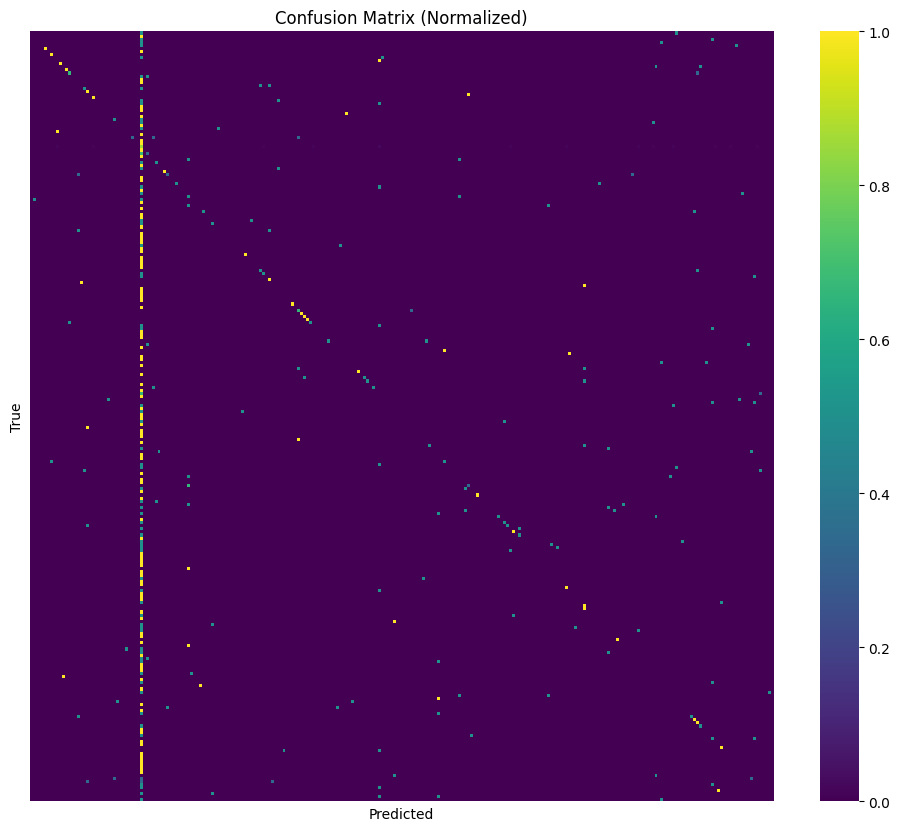

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Run model on test set and collect predictions
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, cmap='viridis', xticklabels=False, yticklabels=False)
plt.title('Confusion Matrix (Normalized)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

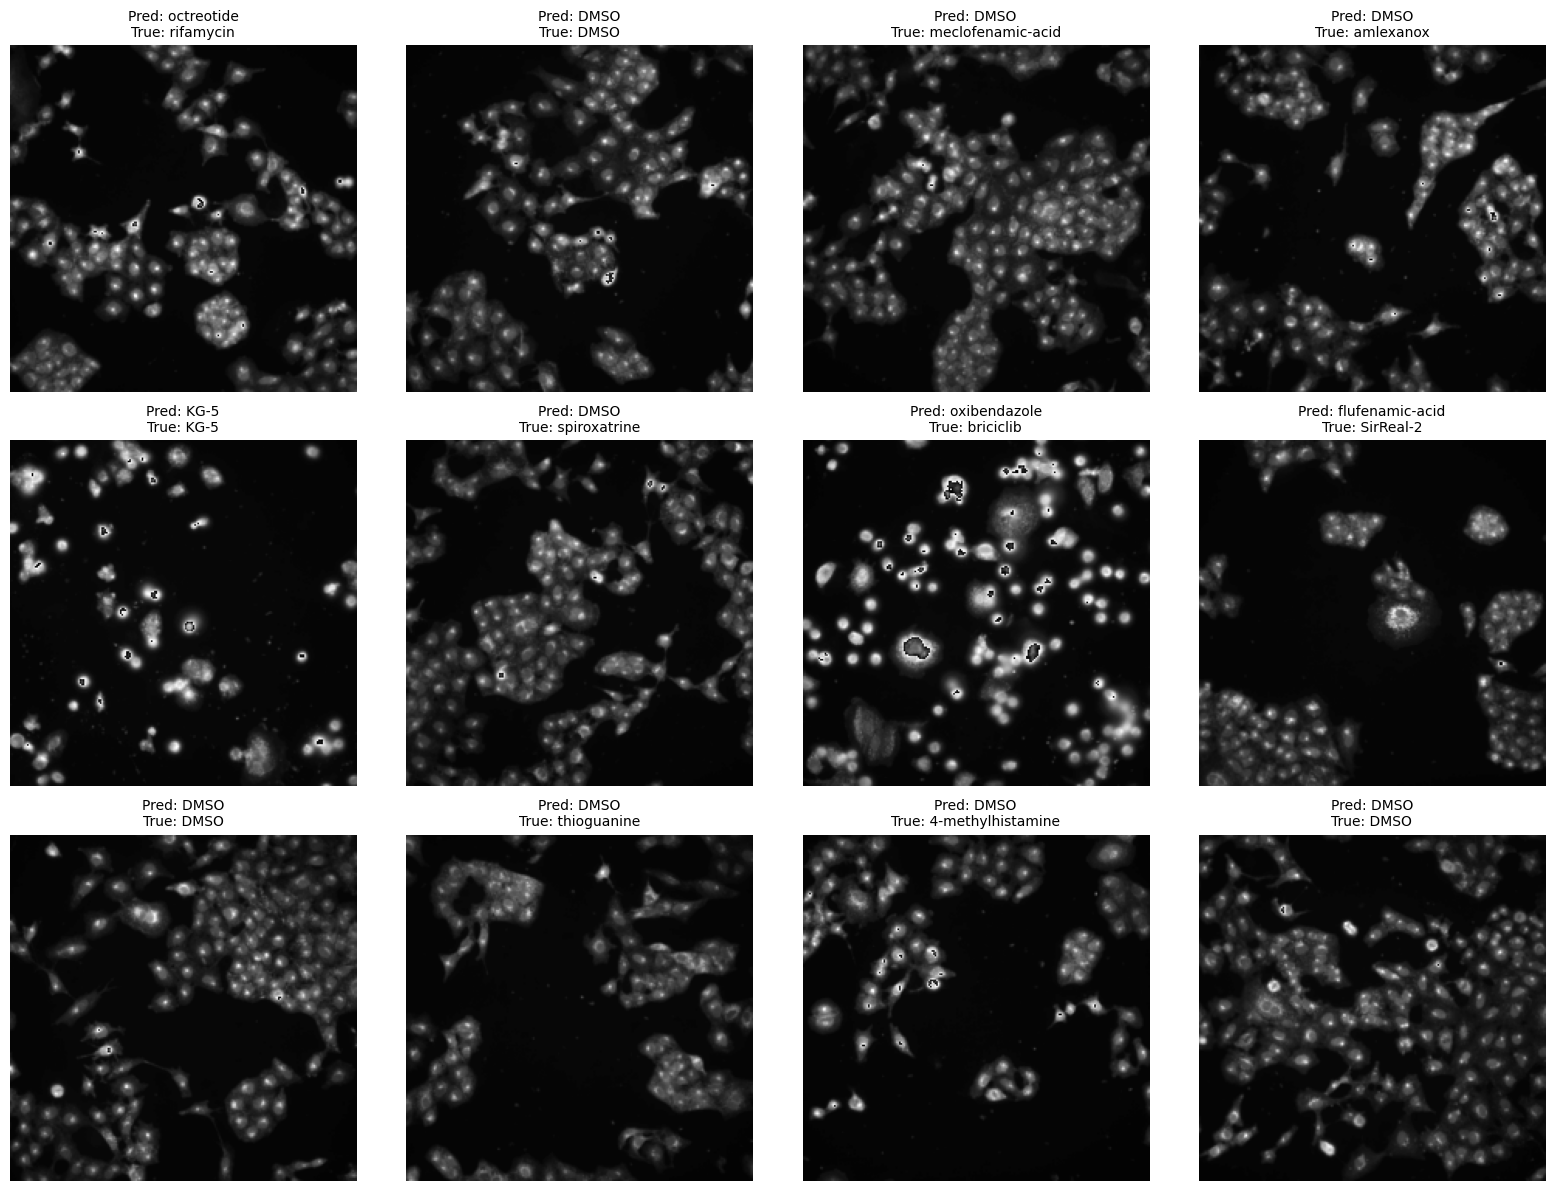

In [43]:
import random
import torchvision.transforms.functional as TF

# Select 12 random samples from the test set
model.eval()
samples = random.sample(range(len(test_dataset)), 12)

plt.figure(figsize=(16, 12))
for i, idx in enumerate(samples):
    image, true_label = test_dataset[idx]
    input_tensor = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        _, pred_label = torch.max(output, 1)

    image_np = TF.to_pil_image(image)
    pred_name = label_encoder.inverse_transform([pred_label.item()])[0]
    true_name = label_encoder.inverse_transform([true_label])[0]

    plt.subplot(3, 4, i + 1)
    plt.imshow(image_np)
    plt.title(f"Pred: {pred_name}\nTrue: {true_name}", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [44]:
!pip install umap-learn

import umap
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [45]:
# Remove final classification layer to get embeddings
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
feature_extractor.eval().to(device)

features = []
labels = []

with torch.no_grad():
    for images, batch_labels in tqdm(test_loader):
        images = images.to(device)
        feats = feature_extractor(images)
        feats = feats.view(images.size(0), -1)  # flatten
        features.append(feats.cpu().numpy())
        labels.extend(batch_labels.numpy())

features = np.concatenate(features)
labels = np.array(labels)

100%|██████████| 18/18 [01:46<00:00,  5.91s/it]


In [46]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(features)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


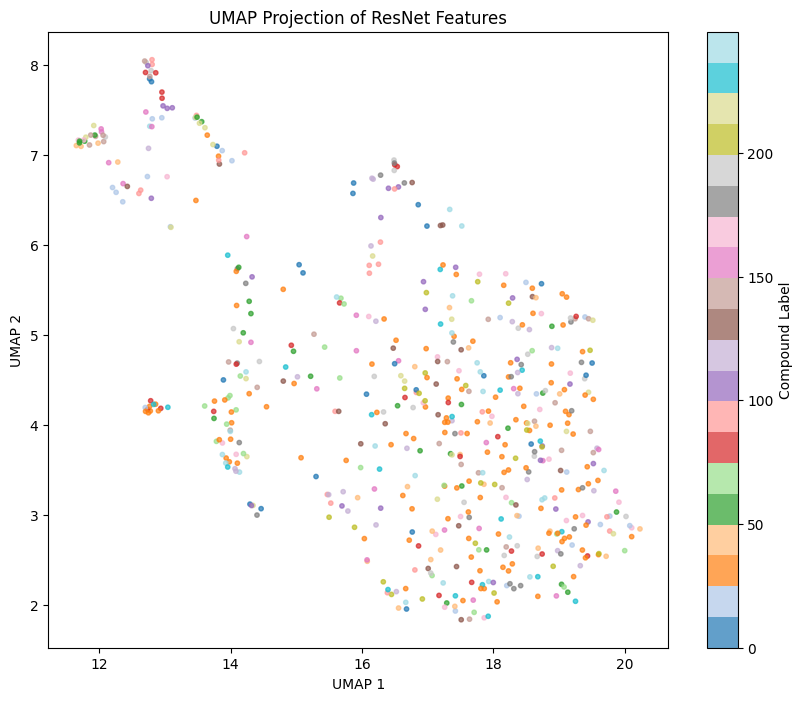

In [47]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='tab20', s=10, alpha=0.7)
plt.title('UMAP Projection of ResNet Features')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar(scatter, label='Compound Label')
plt.show()